In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

PATH = "D:\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"

PARQUET_PATH = rf"{DATA_PROC}/shocks_by_adm"


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
import utils
from tqdm import tqdm
shockname = "drought"
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [3]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61799,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:61824,Total threads: 1
Dashboard: http://127.0.0.1:61827/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:61802,


In [4]:
import numpy as np
import os

files = os.listdir(PARQUET_PATH)
files = [f for f in files if f.endswith(".parquet") and "drought" in f]

def func(partition, partition_info=None):
    try:
        return str(files[partition_info["number"]])
    except:
        print("No info")
        return ""

df = dd.read_parquet(os.path.join(PARQUET_PATH, "drought_*.parquet"))
df["filename"] = ""
df["filename"] = df["filename"].astype(str)
df["filename"] = df["filename"].map_partitions(func, enforce_metadata=True)
df["cells_affected"] = df["cells_affected"].fillna(0).astype(np.uint32)
df["total_cells"] = df["total_cells"].fillna(0).astype(np.uint32)
df["population_affected_n"] = df["population_affected_n"].fillna(0).astype(np.uint64)
df["total_population"] = df["total_population"].fillna(0).astype(np.uint64)

No info


In [17]:
import pandas as pd
df = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\drought_SPI24_25sd_2008_14_zonal_stats.parquet")
df

,cells_affected,total_cells,population_affected_n,total_population
128,NaN,1358,NaN,5.964309e+06
200,NaN,660,NaN,1.549342e+05
391,NaN,21,NaN,2.757014e+05
479,NaN,8,NaN,NaN
537,NaN,564,NaN,4.887228e+04
...,...,...,...,...
36805,1331.0,3919,4639.969355,1.498567e+04
36806,1710.0,6323,416.310517,1.875786e+03
36807,NaN,4447,NaN,3.275058e+03
36808,NaN,4006,NaN,4.117103e+03


In [11]:
from dask.diagnostics import ProgressBar
df.to_parquet(os.path.join(PARQUET_PATH, "droughts.csv"), single_file=True, index=False, compute=True)

No info


KeyboardInterrupt: 

In [ ]:
# Concatenate all the dataframes and create the shock variables
df = dd.concat(dfs)
df = df.groupby(["ID", "name", "year"]).sum()
df["area_affected"] = df["cells_affected"] / df["total_cells"]
df["population_affected"] = df["population_affected_n"] / df["total_population"]
df = (
    df.drop(
        columns=[
            "cells_affected",
            "total_cells",
            "population_affected_n",
            "total_population",
        ]
    )
    .reset_index()
    .fillna(0)
    .replace([np.inf, -np.inf], 0)
)



In [ ]:
path = os.path.join(PARQUET_PATH, f"{shockname}_long.csv")
df.to_csv(path, single_file=True)
print(f"Se creó {path}")

df = pd.read_csv(path)
# Pivot data: every shock has to be a column
pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)

# Reindex the two-level columns pivot returns
newcols = []
for cols in pivot.columns:
    newcols += [utils.parse_columns(cols)]
pivot.columns = newcols
pivot = pivot.reset_index()

path = os.path.join(PARQUET_PATH, f"{shockname}_wide.csv")
pivot.to_csv(path)
print(f"Se creó {path}")

pivot = pd.read_csv(path)

# Add the data to the gdf
out_df = gdf.merge(pivot, left_on="id", right_on="ID", validate="1:m", how="outer")


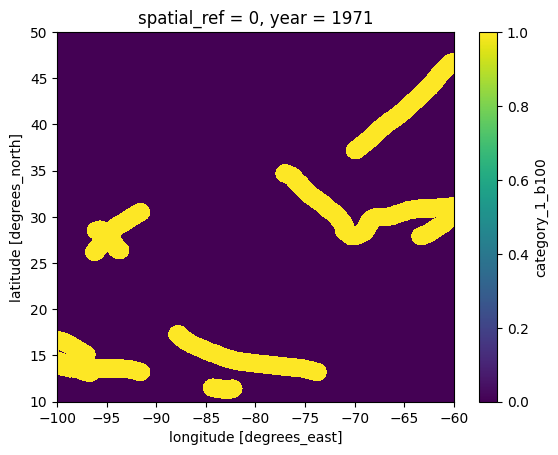

In [14]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_category_1_b100.nc")
# Select Florida
ds = ds.sel(y=slice(50, 10), x=slice(-100, -60))
ds["category_1_b100"].plot()

In [3]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_category_1_b100.nc", chunks={"x": 43200/10, "y": 17173//10})
# # Select Japan 120.937500,20.961441,149.589844,40.713957
# ds = ds.sel(y=slice(40.713957, 20.961441), x=slice(120.937500, 149.589844))
# ds["category_1_b100"].max()

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 1717. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 4320. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


[########################################] | 100% Completed | 10.24 ss


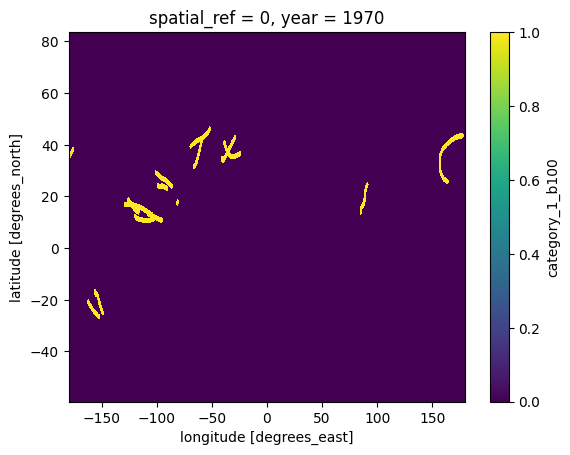

In [22]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    test = ds["category_1_b100"].coarsen(x=10, y=10, boundary="trim").max().plot()

In [11]:
ds.coarsen(x=10, y=10, boundary="pad").max()["category_1_b100"].max()

In [9]:
data = ["D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.25.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_1.0.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_0.5.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1951_0.25.nc"]

data2 = [
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1952_0.25.nc"
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1952_0.25.nc"
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat5_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat4_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat2_1952_0.1.nc",
"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1952_0.1.nc",
# "D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat3_1952_0.25.nc"
]
import xarray as xr
xr.open_mfdataset([data, data2], combine='nested', concat_dim="year")

ValueError: The supplied objects do not form a hypercube because sub-lists do not have consistent lengths along dimension 0

In [4]:
import pandas as pd
import dask.dataframe as dd
df = dd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_SPEI24_15sd_2020_15_zonal_stats.parquet")
df

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


,cells_affected,total_cells,population_affected_n,total_population
npartitions=1,,,,
,float64,int64,float64,float64
,...,...,...,...


In [33]:
import os
import xarray as xr
from dask.diagnostics import ProgressBar

path = r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes"
files = os.listdir(path)
dss = []
for year in range(1970, 2021):
    
    files_year = [os.path.join(path, f) for f in files if f"{year}" in f]
    dss += [xr.open_mfdataset(files_year)]
    
    if year==1975:
        break

ds = xr.concat(dss, dim="time")
with ProgressBar():
    ds.to_netcdf(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_1970_1975.nc")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 1717. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 4320. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 297GB
Dimensions:          (time: 20, y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B 0
    year             (time) int32 80B 1970 1971 1972 1973 ... 1987 1988 1989
Dimensions without coordinates: time
Data variables: (12/20)
    category_1_b10   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_1_b100  (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_1_b25   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_1_b50   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_2_b10   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_2_b100  (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    ...               ...
    category_4_b25   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_4_b50   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b10   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b100  (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b25   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>
    category_5_b50   (time, y, x) bool 15GB dask.array<chunksize=(1, 1717, 4320), meta=np.ndarray>

In [32]:
dss[10]

<xarray.Dataset> Size: 15GB
Dimensions:          (y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B 0
    year             int32 4B 1980
Data variables: (12/20)
    category_1_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    ...               ...
    category_4_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_4_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>

In [24]:
import dask.dataframe as dd
df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks\drought_long.csv")
pivot = df.pivot(
    index=["ID", "year"],
    columns="name",
    values=["population_affected", "area_affected"],
)
pivot

,,population_affected,area_affected
,name,droughtSPEI-12,droughtSPEI-12
ID,year,,
0,1,0.000000,0.000000
1,1,0.000000,0.000000
2,1,0.000000,0.000000
3,1,0.000000,0.000000
4,1,0.000000,0.000000
...,...,...,...
38145,1,0.000000,0.000000
38146,1,0.000000,0.000000


In [28]:
xr.combine_by_coords(dss[1977])

<xarray.Dataset> Size: 15GB
Dimensions:          (y: 17173, x: 43200)
Coordinates:
  * y                (y) float64 137kB 83.62 83.61 83.6 ... -59.46 -59.47 -59.48
  * x                (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    spatial_ref      int32 4B 0
    year             int32 4B 1977
Data variables: (12/20)
    category_1_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_1_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_2_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    ...               ...
    category_4_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_4_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b10   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b100  (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b25   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>
    category_5_b50   (y, x) bool 742MB dask.array<chunksize=(1717, 4320), meta=np.ndarray>

In [7]:
repl = {"year":"y", "lat":"y"}

df.columns

AttributeError: 'Index' object has no attribute 'replace'

In [27]:
import utils



In [85]:
gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")#, "BASIN", "SUBBASIN", "NAME", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "WMO_AGENCY", "TRACK_TYPE"])
gdf["WMO_WIND"] = gdf["WMO_WIND"].ffill()
gdf[gdf.SID == "2021323S10103"].explore(column="WMO_WIND")